**Minimum curvature**

We need a minimum curvature algorithm to interpolate data onto a grid.

.---.---.---


In [1]:
from SimPEG import Mesh
from SimPEG.Utils import mkvc, sdiag, speye
from SimPEG.Utils.meshutils import closestPoints
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

# Start in 1D
mesh = Mesh.TensorMesh([10,10])


I have so far looked at Relaxation method

In [2]:
def MinCurvatureInterp(mesh, pts, vals, tol=1e-5, iterMax=None):
    """
        Interpolate properties with a minimum curvature interpolation
        :param mesh: SimPEG mesh object
        :param pts:  numpy.array of size n-by-3 of point locations
        :param vals: numpy.array of size n-by-m of values to be interpolated
        :return: numpy.array of size nC-by-m of interpolated values

    """

    assert pts.shape[0] == vals.shape[0], ("Number of interpolated pts " +
                                           "must match number of vals")

    # These two functions are almost identical to the ones in Discretize,
    # Only difference is the averaging operator for the boundary cells.
    # Can we add a switch in Discretize to have the options?

    def av_extrap(n):
        """Define 1D averaging operator from cell-centers to nodes."""
        Av = (
            sp.spdiags(
                (0.5 * np.ones((n, 1)) * [1, 1]).T,
                [-1, 0],
                n + 1, n,
                format="csr"
            ) #+
            #sp.csr_matrix(([0.5, 0.5], ([0, n], [0, n-1])), shape=(n+1, n))
        )
        Av[0, 1], Av[-1, -2] = 0.5, 0.5
        return Av

    def aveCC2F(mesh):
        "Construct the averaging operator on cell cell centers to faces."
        if mesh.dim == 1:
            aveCC2F = av_extrap(mesh.nCx)
        elif mesh.dim == 2:
            aveCC2F = sp.vstack((
                sp.kron(speye(mesh.nCy), av_extrap(mesh.nCx)),
                sp.kron(av_extrap(mesh.nCy), speye(mesh.nCx))
            ), format="csr")
        elif mesh.dim == 3:
            aveCC2F = sp.vstack((
                kron3(
                    speye(mesh.nCz), speye(mesh.nCy), av_extrap(mesh.nCx)
                ),
                kron3(
                    speye(mesh.nCz), av_extrap(mesh.nCy), speye(mesh.nCx)
                ),
                kron3(
                    av_extrap(mesh.nCz), speye(mesh.nCy), speye(mesh.nCx)
                )
            ), format="csr")
        return aveCC2F

    Ave = aveCC2F(mesh)

    # Get the grid location
    ijk = closestPoints(mesh, pts, gridLoc='CC')

    count = 0
    residual = 1.

    m = np.zeros(mesh.nC)

    while np.all([count < iterMax, residual > tol]):
        m[ijk] = vals
        mtemp = m
        m = mesh.aveF2CC * (Ave * m)
        residual = np.linalg.norm(m-mtemp)/np.linalg.norm(mtemp)
        count += 1

    return m

In [3]:
pts, vals = np.r_[np.c_[0.4, 0.4],np.c_[0.6, 0.6]], np.r_[1, -1]

mout_SSOR = MinCurvatureInterp(mesh, pts, vals, tol=1e-5, iterMax=200)

C:\Users\DominiqueFournier\Anaconda3\lib\site-packages\scipy\sparse\compressed.py:730: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


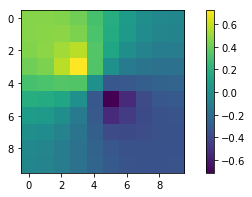

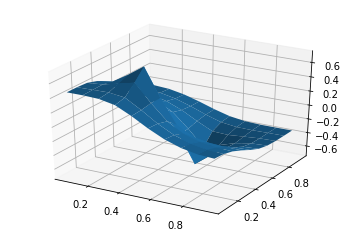

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

# trickery to plot from node to node rather than at cell centers
# z = np.repeat(mesh.vectorNx[1:-1], 2, axis=0)
# z = np.r_[mesh.vectorNx[0], z, mesh.vectorNx[-1]]
# m_plt = np.repeat(mout, 2, axis=0)

# plt.plot(z, m_plt)
# plt.plot(pts, vals, 'r.')
# plt.show()

im = plt.imshow(mout_SSOR.reshape((mesh.nCx,mesh.nCy),order='F'))
plt.colorbar(im)
plt.show()

X = mesh.gridCC[:,0].reshape(mesh.vnC, order='F')
Y = mesh.gridCC[:,1].reshape(mesh.vnC, order='F')

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, mout_SSOR.reshape((mesh.nCx,mesh.nCy),order='F'))

plt.show()

fig.savefig('MinCurv_SSOR.png')

Now trying to do it as a PDE solve.
It should just be in theory solving for the Laplacian

$$  \nabla \cdot \nabla \;m= 0 $$


using the fix values within the grid as boundary conditions.

In [9]:
bind

(array([ True, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False,  True, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False,
        False, False, False, False, False,  True, False, False, False,
        False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False, False,  True, False,
        False, False, False, False, False, False, False, False,  True,
        False, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False, False, False, False, False], dtype=bool),
 array([False, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False,

In [6]:
import scipy.sparse as sp

# Create a Laplacian operator
mesh.setCellGradBC('neumann')
G = mesh.cellGrad
D = mesh.faceDiv
A = G.T*G#sp.vstack([G.T*G,G])

# Get mesh boundary index
bind = mesh.cellBoundaryInd

# Get the grid location
ijk = closestPoints(mesh, pts, gridLoc='CC')
ijk = np.r_[ijk, bind]
nC = len(ijk)

Z = sp.csr_matrix((len(ijk),len(ijk)))
# Diagonal matrix to zero out the gradient on the fix cells
P = speye(mesh.nC)


P = P[ijk,:]

H = sp.vstack([sp.hstack([A.T*A, P.T]),sp.hstack([P,Z])])
# A = Pac * A * Pac

# Create pre-conditioner for speedup
# dA = A.diagonal()
# P = sp.spdiags(1/dA,0,A.shape[0],A.shape[0])
        
BC = np.r_[np.zeros(mesh.nC),np.r_[vals,np.zeros_like(bind)]]

mout_MC = sp.linalg.spsolve(H,BC)

# amp = np.sum(mout**2,axis=1)**0.5
# mout = sdiag(1./amp) * mout

ValueError: all the input arrays must have same number of dimensions

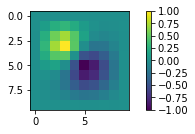

In [7]:
# fig, ax = plt.subplots(1, 1, figsize=(8, 3))

# # trickery to plot from node to node rather than at cell centers
# z = np.repeat(mesh.vectorNx[1:-1], 2, axis=0)
# z = np.r_[mesh.vectorNx[0], z, mesh.vectorNx[-1]]
# m_plt = np.repeat(mout[:mesh.nC], 2, axis=0)

# plt.plot(z, m_plt)
# plt.plot(pts, vals, 'r.')
# plt.show()

plt.subplot(2,1,1)
plt.imshow(mout_MC[:-nC].reshape((mesh.nCx,mesh.nCy),order='F'))
# plt.plot(mesh.gridCC[ijk,0],mesh.gridCC[ijk,1])

plt.colorbar()
plt.show()

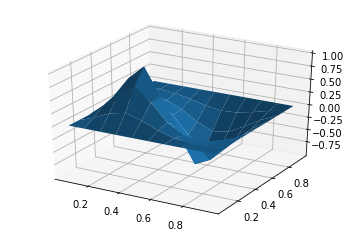

In [14]:
fig = plt.figure()
ax = fig.gca(projection='3d')

X = mesh.gridCC[:,0].reshape(mesh.vnC, order='F')
Y = mesh.gridCC[:,1].reshape(mesh.vnC, order='F')

surf = ax.plot_surface(X, Y, mout_MC[:-nC].reshape((mesh.nCx,mesh.nCy),order='F'))

plt.show()

fig.savefig('MinCurv_PDE.png')